In [1]:
import torch
import torchgeometry as tgm

import cv2

In [2]:
# read the image with OpenCV
image = cv2.imread('./data/bennett_aden.png')[..., (2,1,0)]
print(image.shape)

img = tgm.image_to_tensor(image)
img = torch.unsqueeze(img.float(), dim=0)  # BxCxHxW

(200, 250, 3)


In [3]:
# get random 4 points                                  
_, c, h, w = img.shape  # channels, height, width
norm = torch.rand(1, 4, 2)

# the source points are the image vertexes
points_src = torch.FloatTensor([[
    [80, 30], [170, 30], [170, 120], [80, 120],
    #[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1],
]])
print(points_src)

# get a random destination box
#points_dst = points_src + norm
points_dst = torch.FloatTensor([[
    [0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1],
]])
print(points_dst)
                                                
# compute homography
#H = tgm.find_homography(points_src, points_dst)
#print(H)

H_cv = cv2.findHomography(points_src[0].numpy(), points_dst[0].numpy())[0]
print(H_cv)

H_cv2 = cv2.getPerspectiveTransform(points_src[0].numpy(), points_dst[0].numpy())
print(H_cv2)
print(H_cv2.shape)

H_tgm = tgm.get_perspective_transform(points_src, points_dst)
print(H_tgm)

H_cv=torch.from_numpy(H_cv).float().view(1,3,3)
print(H_cv.shape)
image_warp_cv = cv2.warpPerspective(image, H_cv2, dsize=(w, h))

print((H_tgm[0].numpy()-H_cv).sum())

# warp the original image by the found homography
img_warp = tgm.warp_perspective(img, H_tgm, dsize=(h, w))

# convert back to numpy
image_warp = tgm.tensor_to_image(img_warp.byte())

# draw points into original image
for i in range(4):
    center = tuple(points_src[0, i].long().numpy())
    image = cv2.circle(image.copy(), center, 3, (0, 255, 0), -1)

tensor([[[ 80.,  30.],
         [170.,  30.],
         [170., 120.],
         [ 80., 120.]]])
tensor([[[  0.,   0.],
         [249.,   0.],
         [249., 199.],
         [  0., 199.]]])
[[ 2.76666667e+00 -6.14323407e-16 -2.21333333e+02]
 [ 0.00000000e+00  2.21111111e+00 -6.63333333e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 2.76666667e+00  2.60902411e-15 -2.21333333e+02]
 [-4.60742555e-15  2.21111111e+00 -6.63333333e+01]
 [-5.20417043e-18  2.90566182e-17  1.00000000e+00]]
(3, 3)
tensor([[[   2.7667,   -0.0000, -221.3333],
         [  -0.0000,    2.2111,  -66.3333],
         [   0.0000,   -0.0000,    1.0000]]])
torch.Size([1, 3, 3])
tensor(7.5939e-06)


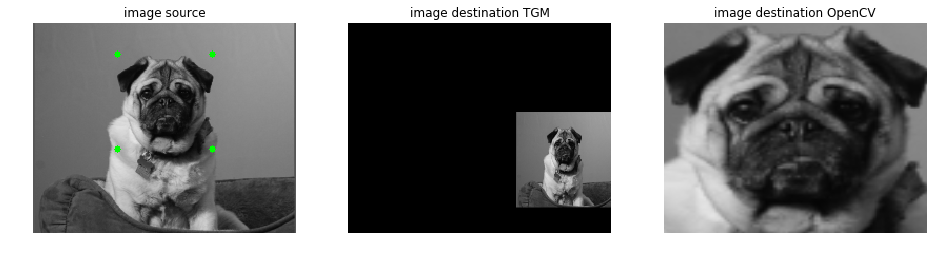

In [4]:
import matplotlib.pyplot as plt 
%matplotlib inline

# create the plot
fig, axs = plt.subplots(1, 3, figsize=(16, 10))
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('image source')
axs[0].imshow(image)

axs[1].axis('off')
axs[1].set_title('image destination TGM')
axs[1].imshow(image_warp)

axs[2].axis('off')
axs[2].set_title('image destination OpenCV')
axs[2].imshow(image_warp_cv)